## FIT5202 - Data processing for Big Data 
### Assignment 1: Analysing Trip Data 





Name: Napoj Thanomkul

Student ID: 32338589

Tutorial number and Tutor name: Laboratory 03, Choiru Za'in and Hongli Song

### Introduction
This assignment will be working on the trip analysis using Pyspark for the given queries.The following assignment consists of three parts including the following:

1. Working with RDDs on trip and passenger dataset
2. Working with DataFrames on all datasets including city,passenger and trip dataset
3. RDDs vs DataFrame vs Spark SQL which using city and trip dataset to comparing performance for each queries

The following below is how the assignment is done.

#### Part 1: Working with RDDs

##### 1.1 Data Preparation and Loading

##### 1.1.1 Create Spark session
Firstly, the Sparksession and SparkConf is created in order to run a session which create SparkContext object performing an RDD within the session as the following:

In [1]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Assignment 1: Analysing Trip Data "
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkSession classes 
from pyspark.sql import SparkSession # Spark SQL

#TODO : Initialize Spark Session and create a SparkContext Object
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

sc

<SparkContext master=local[*] appName=Assignment 1: Analysing Trip Data >

##### 1.1.2 & 1.1.3 Import two files (trip and passengers)
After the session is created, now the current working directory will be identified using `os` library in order to import a trip and passenger csv file into RDDs.

In [2]:
#Getting the current path where the files is collected
import os 
home_path=os.getcwd()

#Import trip and passenger csv file
trip_rdd = sc.textFile(home_path+'/data/trip.csv')
passenger_rdd = sc.textFile(home_path+'/data/passenger.csv')

Once the file are loaded, they will be explored as the following:

In [3]:
#Explore each RDD from trip and passenger file
print('Trip RDD:\n',trip_rdd.take(5),'\n')
print('Passenger RDD:\n',passenger_rdd.take(5))

Trip RDD:
 ['id,driver_id,passenger_id,city_id,call_time,finish_time,surge_rate,trip_distance,trip_fare', 'a84c0db2,cb64172e,2ea4359d,43006,9/8/2019 10:01:28 PM,9/8/2019 10:15:54 PM,0.3,1.92,4.36', 'a84c2d10,3034e6fe,e1bd0c8d,43006,7/1/2019 8:56:28 PM,7/1/2019 9:22:09 PM,0,9.36,6.91', 'a84c3e75,93fb6802,75e6d450,43050,8/20/2019 9:30:46 PM,8/20/2019 9:46:48 PM,0,4.39,3.48', 'a84c3f6f,25fc9273,5ba48e89,43020,9/8/2019 2:42:41 AM,9/8/2019 2:59:56 AM,0,2.04,1.54'] 

Passenger RDD:
 ['id,first_call_time', '00000fab,5/11/2019 8:23:54 PM', '0000149d,12/24/2018 9:21:33 PM', '00002b66,9/20/2018 9:08:24 PM', '00002bc7,7/28/2019 11:27:56 AM']


##### 1.1.4 Remove header and show first five rows of each file with their counts
Based on the file output, it seems that they consist of the header so we have to remove it by using `.filter` combining with `.first` to identify the header and exclude them from each rdd and display the first five rows and the counts using `.count` after the header is removed as the following:

In [4]:
#Remove the header
trip_header=trip_rdd.first()
passenger_header=passenger_rdd.first()

trip_rdd = trip_rdd.filter(lambda x: x != trip_header)
passenger_rdd= passenger_rdd.filter(lambda x: x!=passenger_header)

In [5]:
#Total count and the first five rows

print('Trip RDD total count:',trip_rdd.count(),'\n',trip_rdd.take(5),'\n')
print('Passenger RDD total count:',passenger_rdd.count(),'\n',passenger_rdd.take(5))

Trip RDD total count: 2318357 
 ['a84c0db2,cb64172e,2ea4359d,43006,9/8/2019 10:01:28 PM,9/8/2019 10:15:54 PM,0.3,1.92,4.36', 'a84c2d10,3034e6fe,e1bd0c8d,43006,7/1/2019 8:56:28 PM,7/1/2019 9:22:09 PM,0,9.36,6.91', 'a84c3e75,93fb6802,75e6d450,43050,8/20/2019 9:30:46 PM,8/20/2019 9:46:48 PM,0,4.39,3.48', 'a84c3f6f,25fc9273,5ba48e89,43020,9/8/2019 2:42:41 AM,9/8/2019 2:59:56 AM,0,2.04,1.54', 'a84c5ce2,484c4d0c,fdb2ef59,43006,6/10/2019 9:29:18 AM,6/10/2019 9:55:36 AM,0,7.37,5.83'] 

Passenger RDD total count: 1235782 
 ['00000fab,5/11/2019 8:23:54 PM', '0000149d,12/24/2018 9:21:33 PM', '00002b66,9/20/2018 9:08:24 PM', '00002bc7,7/28/2019 11:27:56 AM', '0000332e,2/21/2019 11:34:24 PM']


##### 1.2 Data Partitioning in RDD
##### 1.2.1  Getting the default partitions
After we have explore the first five rows of each rdds, we will look at the number of partitions by defaults for each rdd by using `.getNumPartitions()` 

In [6]:
#Number of partitions of each rdd(trip and passengers)
print(f'Default partitions:{trip_rdd.getNumPartitions()}')
print(f'Default partitions:{passenger_rdd.getNumPartitions()}')

Default partitions:6
Default partitions:2


##### 1.2.2 a. key/value of passenger 
Based on the result above, it seems that trip file got 6 as the default number of partition and the passenger file got 2 partitions as a defaults. Next the `first_call_time` column's values in passenger.csv file will be change to either `In 2019` or `Not in 2019`to identify whether the first call time is on 2019. This change will be used for creating a key/value pair for passenger rdd and they will be showed in the first five pairs as the following:

In [7]:
#Change the element in the rdd into key/value pair
pass_pair = passenger_rdd.map(lambda x:x.split(',')).map(lambda x:('In 2019' if '2019' in x[1] else 'not 2019',
                                                                   x[0]))
pass_pair.take(5)

[('In 2019', '00000fab'),
 ('not 2019', '0000149d'),
 ('not 2019', '00002b66'),
 ('In 2019', '00002bc7'),
 ('In 2019', '0000332e')]

##### 1.2.2 b. & c. Using hash partitioning to make partition for In 2019 and Not in 2019 pairs and show the number of record in each partitions.
Then, the hash function will be created to separate the `In 2019` and `Not in 2019` into their own partition the reason for using the hash partition because there is a condition for creating a partition. In the following case, it is the partitons based on the `In 2019` and `Not in 2019`which is more efficient than other partitioning approaches. After that, the number of each records will be showed by using `.glom()`, `.map(len)` and .`collect` to show each partition records.

In [8]:
#Partition based on the 2019 or not 2019 using hash function
def hash_2019(key):
    total = 0
    if 'In 2019'in key:
        total = 0
    else:
        total=1
    return(total)
        
partition_pass_pair=pass_pair.partitionBy(2,hash_2019)
partition_pass_pair.getNumPartitions()           

#Show number of each records
print(f'Number of the first partition(In 2019):{partition_pass_pair.glom().map(len).collect()[0]} records')
print(f'Number of the second partition(Not in 2019):{partition_pass_pair.glom().map(len).collect()[1]} records')

#Show all the record using glom to show each partition in list
partition_pass_pair.glom().collect()

Number of the first partition(In 2019):556856 records
Number of the second partition(Not in 2019):678926 records


[[('In 2019', '00000fab'),
  ('In 2019', '00002bc7'),
  ('In 2019', '0000332e'),
  ('In 2019', '000048aa'),
  ('In 2019', '0000497f'),
  ('In 2019', '000070ff'),
  ('In 2019', '0000883c'),
  ('In 2019', '00009e18'),
  ('In 2019', '0000a7b0'),
  ('In 2019', '0000ccab'),
  ('In 2019', '0000cf08'),
  ('In 2019', '0000da1f'),
  ('In 2019', '0000e207'),
  ('In 2019', '0000e5a3'),
  ('In 2019', '00010e2d'),
  ('In 2019', '00012136'),
  ('In 2019', '00017030'),
  ('In 2019', '000180ec'),
  ('In 2019', '0001950a'),
  ('In 2019', '0001a2c5'),
  ('In 2019', '0001b7fa'),
  ('In 2019', '0001cc4c'),
  ('In 2019', '00020361'),
  ('In 2019', '00020f9d'),
  ('In 2019', '0002242e'),
  ('In 2019', '000225cd'),
  ('In 2019', '00029b80'),
  ('In 2019', '0002a914'),
  ('In 2019', '0002b566'),
  ('In 2019', '0002b8fb'),
  ('In 2019', '0002c1d0'),
  ('In 2019', '0002c90f'),
  ('In 2019', '00031f9d'),
  ('In 2019', '00032799'),
  ('In 2019', '00033c92'),
  ('In 2019', '00036f9c'),
  ('In 2019', '0003ca4d'),
 

#### 1.3 Query/Analysis
##### 1.3.1 Identify null in trip_distance surge_rate and comparing the trip count before and after filtering
In the following part, the null in trip_distance and surge_rate will be identify and removed them. Then both of the rdd with and without filtering count will be compared with one another as the following:

In [9]:
#Identify Null in the trip_distance and surge_rate
trip_no_null = trip_rdd.map(lambda x:x.split(',')).filter(lambda x:x[6]!='' and x[7]!='')

In [10]:
#Print the count of filtering and none filtering trip rdd
print(f'Trip RDD after filtering:{trip_no_null.count()} records')
print(f'Trip RDD before filtering:{trip_rdd.count()} records')

#Print the first five rows of filtering trip rdd
trip_no_null.take(5)

Trip RDD after filtering:2295112 records
Trip RDD before filtering:2318357 records


[['a84c0db2',
  'cb64172e',
  '2ea4359d',
  '43006',
  '9/8/2019 10:01:28 PM',
  '9/8/2019 10:15:54 PM',
  '0.3',
  '1.92',
  '4.36'],
 ['a84c2d10',
  '3034e6fe',
  'e1bd0c8d',
  '43006',
  '7/1/2019 8:56:28 PM',
  '7/1/2019 9:22:09 PM',
  '0',
  '9.36',
  '6.91'],
 ['a84c3e75',
  '93fb6802',
  '75e6d450',
  '43050',
  '8/20/2019 9:30:46 PM',
  '8/20/2019 9:46:48 PM',
  '0',
  '4.39',
  '3.48'],
 ['a84c3f6f',
  '25fc9273',
  '5ba48e89',
  '43020',
  '9/8/2019 2:42:41 AM',
  '9/8/2019 2:59:56 AM',
  '0',
  '2.04',
  '1.54'],
 ['a84c5ce2',
  '484c4d0c',
  'fdb2ef59',
  '43006',
  '6/10/2019 9:29:18 AM',
  '6/10/2019 9:55:36 AM',
  '0',
  '7.37',
  '5.83']]

##### 1.3.2 Calculate the average surge rate for each city
In this part, the average surge rate will be calculate using `mapValues` to count each record as one and using `reducingbyKey` to sum all the count value based on `city_id` and show the result with `mapValues` with using average calculation which is the value divided by all the count record based on city_id.

In [11]:
#Filter the no null rdd of trip to city id and surge rate
trip_city_surge = trip_no_null.map(lambda x:(x[:][3],float(x[:][6])))
trip_city_surge = trip_city_surge.mapValues(lambda x: (x, 1))\
    .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
    .mapValues(lambda x:x[0]/x[1])
trip_city_surge.collect()


[('43020', 0.03600285427063479),
 ('43050', 0.05545981386673684),
 ('43278', 0.022864212716075583),
 ('43116', 0.059504653033246084),
 ('43006', 0.03495577782547935),
 ('43179', 0.07075066034400256)]

##### 1.3.3 Driver ID with min and max trip distance
Firstly we will using filter to find whether there is a negative value in trip distance as the following:

In [12]:
#Check whether if there is any negative trip distance with filter
negative_trip=trip_no_null.filter(lambda x:'-'in x[7])
print(negative_trip.take(3))

[['a85169d3', 'e6ebe10a', '272a2191', '43116', '9/6/2019 5:48:27 AM', '9/6/2019 6:06:39 AM', '0', '-0.12', '4.54'], ['a862eccf', 'eedb9bde', 'eb7d893e', '43179', '8/27/2019 9:08:33 AM', '8/27/2019 9:10:04 AM', '0.5', '-0.31', '2.07'], ['a873c808', '5b978ed9', 'a5a64250', '43020', '7/27/2019 10:10:04 PM', '7/27/2019 10:12:47 PM', '0', '-0.41', '3.24']]


Based on the output above, it seems that there is negative value in the trip distance so it is confidence that the min trip distance must be negative value. After that, we will find driver_id with max and min trip_distance using `.max` and `.min` and show all the trip occur by these driver_id as the following:

In [13]:
#Identify driver id which got max and min travel distance
result_max = trip_no_null.max(key=lambda x: float(x[7]))
result_min = trip_no_null.filter(lambda x:'-'in x[7]).min(key=lambda x:float(x[7]))
print(f'Max trip:{result_max}')
print(f'Min trip:{result_min}')

#Identify all the trip make by this driver_id
max_driver_id = result_max[1]
min_driver_id = result_min[1]

max_trip = trip_no_null.filter(lambda x: x[1] == max_driver_id)
min_trip = trip_no_null.filter(lambda x: x[1] == min_driver_id)

print(f'{max_driver_id} all trip:\n{max_trip.collect()}\n')
print(f'{min_driver_id} all trip:\n{min_trip.collect()}')

Max trip:['7f4a1ec5', '704642b5', '771e01b2', '43116', '5/10/2019 2:40:27 AM', '5/10/2019 7:53:42 AM', '0', '296.1', '136.37']
Min trip:['abe60002', '3a9c0391', 'a7b6299e', '43179', '6/4/2019 4:59:51 AM', '6/4/2019 5:10:33 AM', '0', '-0.5', '3.12']
704642b5 all trip:
[['c7d3b537', '704642b5', '7911406f', '43116', '8/3/2019 8:05:49 AM', '8/3/2019 8:25:20 AM', '0', '3.21', '1.66'], ['1240b566', '704642b5', '106e0be6', '43116', '7/5/2019 6:20:55 PM', '7/5/2019 6:50:06 PM', '0', '11.09', '4.55'], ['5189f92a', '704642b5', 'a1f12605', '43116', '7/18/2019 11:56:14 PM', '7/19/2019 12:05:16 AM', '0', '2.61', '1.2'], ['75f5bbc7', '704642b5', '5c12690c', '43116', '7/3/2019 2:58:20 AM', '7/3/2019 3:25:53 AM', '0', '11.7', '4.01'], ['e22d78b7', '704642b5', '7d81049e', '43116', '5/15/2019 10:40:45 PM', '5/15/2019 10:54:24 PM', '0', '4.65', '5.31'], ['3d98b2f8', '704642b5', 'ee6111f1', '43116', '7/20/2019 12:24:03 AM', '7/20/2019 1:02:31 AM', '0', '10.42', '8.7'], ['5863225b', '704642b5', 'a39a07f0',

Now the first part is finished, we will move on to part 2 .

#### Part 2. Working with DataFrames

#### 2.1 Data Preparation and Loading
The second part starting with loading all the dataset into a pyspark dataframe using `spark.read.format().options().load()` in the `options` the parameter will be set with `inferSchema`= 'True' so that the schema can be printout usinf `.printSchema()`.

In [14]:
#Import all the file into a dataframe
trip_df=spark.read.format('csv').options(header='True', inferSchema='True').load(home_path+'/data/trip.csv')
pass_df=spark.read.format('csv').options(header='True', inferSchema='True').load(home_path+'/data/passenger.csv')
city_df=spark.read.format('csv').options(header='True', inferSchema='True').load(home_path+'/data/city.csv')

In [15]:
#Print their schema
trip_df.printSchema()
pass_df.printSchema()
city_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- passenger_id: string (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- call_time: string (nullable = true)
 |-- finish_time: string (nullable = true)
 |-- surge_rate: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_fare: double (nullable = true)

root
 |-- id: string (nullable = true)
 |-- first_call_time: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)



##### 2.2 Query/Analysis
##### 2.2.1 Rename id in city dataframe into city_id
After import the file into dataframes, we will rename the id in the city dataframe into city_id with `.withColumnRenamed` as the following:

In [16]:
#Rename the id in city dataframe to city_id
city_df= city_df.withColumnRenamed('id','city_id')
city_df.printSchema()

root
 |-- city_id: integer (nullable = true)
 |-- name: string (nullable = true)



##### 2.2.2 Join city DF with trip DF
Next, the city dataframe and trip dataframe will be joined together using `.join` function and put `how = 'inner'` for making an inner join between these two dataframe ane drop the city_id column and rename the name column into city as the following:

In [17]:
#Inner join between city and trip dataframe and rename of name column
join_city_trip=city_df.join(trip_df,city_df.city_id==trip_df.city_id,how='inner')
join_city=join_city_trip.drop('city_id')
join_city=join_city.withColumnRenamed('name','city')
join_city.show()

+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019 9:55:36 AM|       0.0|         7.37|     5.83|
|   Rive

##### 2.2.3 Use joined DF above in 2.2.2, keep the rows in which trip_distance and trip_fare is both larger than 0. Show 5 records after filtering. 
As the instruction described here, the `col` function is imported to be used here with `filter` to get the rows which trip_distance and trip_fare larger than 0. Then, the first five report will be shown using `.show` with 5 as parameter as the following:

In [18]:
#Filtering trip_distance and trip_fare
from pyspark.sql.functions import col

filter_join_df=join_city.filter((col('trip_distance')>0)&(col('trip_fare')>0))
filter_join_df.show(5)

+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019 9:55:36 AM|       0.0|         7.37|     5.83|
+-------

##### 2.2.4. Use the filtered DF above in 2.2.3, show top 5 rows using descending order of  trip_distance. (‘id’, ‘driver_id’, ‘passenger_id’ and ‘trip_distance’ should be displayed)

After the previous part, the filtered dataframe will be sorted in descending order using `.sort()` on the `trip_distance` and `ascending = False`. Also, the columns which will be selected to displayed are `id`,`driver_id`,`passenger_id`, and `trip_distance`using `.select` function. Then, the first five report will be shown.


In [19]:
#Sort the dataframe descending order
top_five_df=filter_join_df.select('id','driver_id','passenger_id','trip_distance').sort('trip_distance', ascending=False)
top_five_df.show(5)

+--------+---------+------------+-------------+
|      id|driver_id|passenger_id|trip_distance|
+--------+---------+------------+-------------+
|7f4a1ec5| 704642b5|    771e01b2|        296.1|
|30bb5f34| 7119b481|    d5e5e5d8|       261.71|
|ac1861e1| ceccad76|    2a2f3fc5|       244.82|
|4525a2bf| bdb22ca4|    b7f9f488|       236.14|
|b60c4614| 70b9733e|    09ec3959|       235.42|
+--------+---------+------------+-------------+
only showing top 5 rows



##### 2.3 Trip Analysis
##### 2.3.1 Create On Holiday column to identify whether  the trip happen on holiday
In this section, the `udf` function will be created to identify whether the `call_time` date on the holiday list as the following '1/1/2019', '3/5/2019', '4/19/2019', '4/21/2019', '5/1/2019', '6/20/2019', '9/7/2019', '10/12/2019', '11/2/2019', '11/15/2019', '12/25/2019'. UDF is created using the `udf` function with the create function and using `StringType` to make the column On_Holiday a string type.

In [20]:
#1. Calling the UDF with DataFrame
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

#Holiday list
holiday=['1/1/2019', '3/5/2019', '4/19/2019', '4/21/2019', '5/1/2019', '6/20/2019', 
'9/7/2019', '10/12/2019', '11/2/2019', '11/15/2019', '12/25/2019']

#2. Create function to extract
def holiday_check(s):
    s=s.split(' ')[0].strip() #split the date space and strip white space
    check=0
    if s in holiday:#Show true if the split date in holiday list false if not
        check='true'
    else:
        check='false'
    return(check)

#UDF for create On Holiday column
holiday_udf=udf(holiday_check,StringType())

#Call the function and name the column using withColumn
new_join_df=join_city.withColumn("On Holiday",holiday_udf('call_time'))
new_join_df.show(60)

+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+----------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|On Holiday|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+----------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|     false|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|     false|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|     false|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|     false|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019

##### 2.3.2 Observe whether holidays have any effect on the average trip fare in various cities into a dataframe and SQL
Now we will use the `select` function on the selected column `city`,`On Holiday`, `trip_fare` and using `groupby` with `agg` function with `F.` along with mean to calculate average of trip fare by each city for dataframe part. For sql we need to calculate average using `AVG` and `GROUP BY` `city` and `On Holiday`

In [21]:
#Create view for the dataframe
new_join_df.createOrReplaceTempView("sql_on_holiday")

import pyspark.sql.functions as F

#### Aggregate the dataset by 'Year' and count the total number of athletes using Dataframe
new_join1_df = new_join_df.select('city','On Holiday','trip_fare')
new_join1_df.groupby('city','On Holiday').agg(F.mean('trip_fare').alias('avg_trip_fare'))\
.sort('City', ascending=True).show()

sql_mean = spark.sql('''SELECT city,`On Holiday`,AVG(trip_fare) as
    avg_trip_fare
    FROM sql_on_holiday
    GROUP BY city,`On Holiday`
    ORDER BY city''')
sql_mean.show()

+------------+----------+------------------+
|        city|On Holiday|     avg_trip_fare|
+------------+----------+------------------+
|      Gondor|     false|  5.13122212820313|
|      Gondor|      true|5.4218031555221575|
|    Isengard|     false| 5.550994994344451|
|    Isengard|      true| 5.690277565084232|
|Minas Tirith|      true|  5.22092199619494|
|Minas Tirith|     false| 4.969949667768408|
|   Rivendell|      true| 5.851725862931469|
|   Rivendell|     false| 5.669180818214374|
|       Rohan|      true| 5.455164385996093|
|       Rohan|     false| 5.276064985963267|
|   The Shire|      true| 5.189087501615612|
|   The Shire|     false| 4.995571570029671|
+------------+----------+------------------+

+------------+----------+------------------+
|        city|On Holiday|     avg_trip_fare|
+------------+----------+------------------+
|      Gondor|      true|5.4218031555221575|
|      Gondor|     false|  5.13122212820313|
|    Isengard|     false| 5.550994994344451|
|    Isen

Based on the result above, it seems that most of the city except Isengard have more average trip fare during the holiday. This result mean that holiday might result in increase in trip_fare. 

##### 2.3.3 Create a new column called 'weekday' which  transfers the 'call_time' column to 'MON,'TUE','WED... and sort top 5
In this part, UDF function will be created based on the manipulation of the `call_time` string. Using UDF to extract date string , then using `to_date` to change the date type variable to date type and change format with `date_format` with `E` for getting initial of each day.Lastly using `.upper` to make all the day initial in `weekday` column in a capital letter and show the top 5 rows as the following.

In [22]:
from pyspark.sql.functions import to_date,date_format,upper
from pyspark.sql.types import DateType
from datetime import datetime #using this to extract the date from call_time

#1. Create function to extract date string
def date_change(date):
    date=date.split(' ')[0].strip()
    date= datetime.strptime(date, '%m/%d/%Y')
    return(date)

#UDF function for create a date variable with DateType
daycheck_udf=udf(date_change,DateType())

#2.Call the function to extract date string
new_join2_df= join_city.withColumn("weekday",daycheck_udf('call_time'))

#Change the date format using to_date and date_format to initial of each week day
new_join2_df=new_join2_df.withColumn("weekday",to_date(new_join2_df.weekday,'M/dd/yyyy')) 
new_join2_df=new_join2_df.withColumn("weekday",date_format('weekday', 'E'))
new_join2_df=new_join2_df.withColumn("weekday",upper('weekday'))

new_join2_df.show(5)

+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+-------+
|        city|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|weekday|
+------------+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+-------+
|Minas Tirith|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|    SUN|
|Minas Tirith|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|    MON|
|      Gondor|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|    TUE|
|    Isengard|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|    SUN|
|Minas Tirith|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019

#### 2.3.4 Compute the total number of the trip (number of rows) for each weekday in different cities and the percentage for the 7 different weekdays

Firstly, we need to use the `F.count` to make a count of each city and weekday and change the `Count` column into integer tupe using `.cast`with`IntegerType` as the following:

In [23]:
from pyspark.sql.types import IntegerType

#Create count column
new_join3_df=new_join2_df.groupby('city','weekday').agg(F.count('weekday').alias('Count')).sort('city', ascending=True)
new_join3_df=new_join3_df.withColumn('Count',F.col('Count').cast(IntegerType()))
new_join3_df.show(42)

+------------+-------+-----+
|        city|weekday|Count|
+------------+-------+-----+
|      Gondor|    FRI|45623|
|      Gondor|    SUN|52755|
|      Gondor|    WED|40900|
|      Gondor|    SAT|51117|
|      Gondor|    MON|45502|
|      Gondor|    THU|42607|
|      Gondor|    TUE|39995|
|    Isengard|    SAT|57867|
|    Isengard|    FRI|49305|
|    Isengard|    MON|43823|
|    Isengard|    TUE|41060|
|    Isengard|    SUN|55741|
|    Isengard|    WED|43526|
|    Isengard|    THU|46326|
|Minas Tirith|    TUE|53583|
|Minas Tirith|    FRI|61216|
|Minas Tirith|    THU|57369|
|Minas Tirith|    SUN|67379|
|Minas Tirith|    MON|53856|
|Minas Tirith|    WED|55876|
|Minas Tirith|    SAT|69616|
|   Rivendell|    FRI|53027|
|   Rivendell|    THU|48803|
|   Rivendell|    SUN|69820|
|   Rivendell|    WED|47936|
|   Rivendell|    MON|58549|
|   Rivendell|    SAT|64014|
|   Rivendell|    TUE|46315|
|       Rohan|    SAT|59630|
|       Rohan|    WED|45848|
|       Rohan|    TUE|45175|
|       Rohan|

Then, the UDF function will be created to calculate percentage of count by each city per day along with `.over` and `Window.partitionby`to calculate total as a column for each city and using udf for calculate percentages as the following:

In [24]:
#Import window function for condition of sum over multiple columns and floattype
from pyspark.sql import Window
from pyspark.sql.types import FloatType
#Create UDF function
def percent_count(count,total):
    return count/total

percent_udf=udf(percent_count,FloatType())

#Sum between different column (GeeksforGeeks,2021)
new_join3_df=new_join3_df.withColumn('Total', F.sum('Count').over(Window.partitionBy('city')))
new_join3_df=new_join3_df.withColumn('Percentage',percent_udf('Count','Total'))
new_join3_df=new_join3_df.drop('Total')
new_join3_df.show()

+------------+-------+-----+----------+
|        city|weekday|Count|Percentage|
+------------+-------+-----+----------+
|      Gondor|    SUN|52755|0.16563632|
|      Gondor|    MON|45502|0.14286387|
|      Gondor|    WED|40900|0.12841484|
|      Gondor|    FRI|45623|0.14324377|
|      Gondor|    SAT|51117|0.16049343|
|      Gondor|    TUE|39995| 0.1255734|
|      Gondor|    THU|42607|0.13377436|
|    Isengard|    MON|43823|0.12978901|
|    Isengard|    SUN|55741|0.16508612|
|    Isengard|    FRI|49305|0.14602485|
|    Isengard|    SAT|57867|0.17138262|
|    Isengard|    THU|46326|0.13720205|
|    Isengard|    TUE|41060|0.12160593|
|    Isengard|    WED|43526| 0.1289094|
|Minas Tirith|    WED|55876|0.13338904|
|Minas Tirith|    FRI|61216|0.14613687|
|Minas Tirith|    MON|53856|0.12856683|
|Minas Tirith|    SUN|67379|0.16084938|
|Minas Tirith|    THU|57369|0.13695318|
|Minas Tirith|    TUE|53583|0.12791511|
+------------+-------+-----+----------+
only showing top 20 rows



##### 2.3.5 Draw a bar chart using ‘city’, ‘weekday’, and ‘Percentage’ we generated in 2.3.4 using matplotlib
In the last section of part 2., the `Count` column will be drop and the pyspark dataframe will be changed to pandas dataframe using `.toPandas()`. Then, the dataframe will be change to wide form using `.pivot` for the bar plot of the percentage by city each day as the following:

In [25]:
#Drop count column and make pyspark dataframe to pandas dataframe
import matplotlib.pyplot as plt
new_df=new_join3_df.drop('Count')
new_joinp_df=new_df.toPandas()
new_joinp_df

,city,weekday,Percentage
0,Gondor,SUN,0.165636
1,Gondor,MON,0.142864
2,Gondor,WED,0.128415
3,Gondor,FRI,0.143244
4,Gondor,SAT,0.160493
5,Gondor,TUE,0.125573
6,Gondor,THU,0.133774
7,Isengard,MON,0.129789
8,Isengard,SUN,0.165086
9,Isengard,FRI,0.146025


In [26]:
#Make the df into wide form for convenient plot
wide_df=new_joinp_df.pivot(index='city',columns='weekday',values='Percentage')
wide_df

weekday,FRI,MON,SAT,SUN,THU,TUE,WED
city,,,,,,,
Gondor,0.143244,0.142864,0.160493,0.165636,0.133774,0.125573,0.128415
Isengard,0.146025,0.129789,0.171383,0.165086,0.137202,0.121606,0.128909
Minas Tirith,0.146137,0.128567,0.166190,0.160849,0.136953,0.127915,0.133389
Rivendell,0.136504,0.150719,0.164787,0.179734,0.125631,0.119226,0.123399
Rohan,0.144084,0.143351,0.163192,0.168359,0.131906,0.123633,0.125474
The Shire,0.150760,0.124471,0.170210,0.151920,0.141478,0.126151,0.135010


<AxesSubplot:title={'center':'Percentage of trip by weekdays per city'}, xlabel='city'>

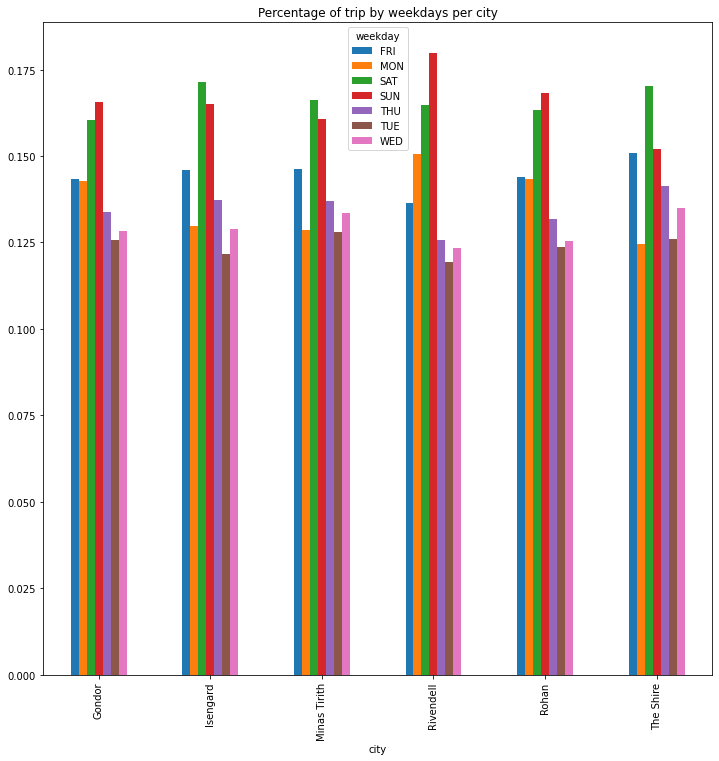

In [27]:
fig,ax=plt.subplots(figsize=(12,12))
wide_df.plot(kind='bar',stacked=False,title='Percentage of trip by weekdays per city',ax=ax)

Based on the plot, it seems that day have an effect on the number of trip in each city. Every city got high number of trip on weekends (Satureday and Sunday) and on Friday. Except Rivendell which have the third highest number of trip is on Monday. In conclusion, it seems that the number of trip is gradually increase starting from Tuesday to Sunday which is at it peak number for most cities except Isengard, Minas Tirith, and The Shire which peak at Saturday.

#### 3. RDDs vs DataFrame vs Spark SQL

In the last section, we will do all the type of data partition consist of RDD,dataframes, and SQL on a query joining the city and trip file together based on city_id with only data for Minas Tirith city. Then show the result with id trip and city name as the following:

##### RDD

In [28]:
#RDD call time
#Import trip and passenger csv file
trip_rdd = sc.textFile(home_path+'/data/trip.csv')
city_rdd = sc.textFile(home_path+'/data/city.csv')

#split the value inside rdd by comma
trip_rdd= trip_rdd.map(lambda x:x.split(','))
city_rdd = city_rdd.map(lambda x:x.split(','))

#Identify the header of each rdd
trip_rdd_header = trip_rdd.first() 
city_rdd_header = city_rdd.first()

#Filter the rdd based on the instruction: select on Minas Tirith and remove header
trip_rdd = trip_rdd.filter(lambda x: x != trip_rdd_header).map(lambda x:(x[3],x[0]))
city_rdd = city_rdd.filter(lambda x: x != city_rdd_header).map(lambda x:(x[0],x[1])).filter(lambda x:x[1]=='Minas Tirith')

In [29]:
%%time

#Join both rdd and show the result and the execution time
city_trip_rdd=trip_rdd.join(city_rdd)
city_trip_rdd.collect()

CPU times: user 58.3 ms, sys: 6.05 ms, total: 64.3 ms
Wall time: 3.68 s


[('43006', ('a84c0db2', 'Minas Tirith')),
 ('43006', ('a84c2d10', 'Minas Tirith')),
 ('43006', ('a84c5ce2', 'Minas Tirith')),
 ('43006', ('a84ceb22', 'Minas Tirith')),
 ('43006', ('a84d29a0', 'Minas Tirith')),
 ('43006', ('a84d31ee', 'Minas Tirith')),
 ('43006', ('a84d8d16', 'Minas Tirith')),
 ('43006', ('a84dbd8a', 'Minas Tirith')),
 ('43006', ('a84dc20a', 'Minas Tirith')),
 ('43006', ('a84dfcb7', 'Minas Tirith')),
 ('43006', ('a84f80fa', 'Minas Tirith')),
 ('43006', ('a84fc521', 'Minas Tirith')),
 ('43006', ('a850834f', 'Minas Tirith')),
 ('43006', ('a850c3de', 'Minas Tirith')),
 ('43006', ('a850de4c', 'Minas Tirith')),
 ('43006', ('a851b2b2', 'Minas Tirith')),
 ('43006', ('a8528280', 'Minas Tirith')),
 ('43006', ('a852a3b2', 'Minas Tirith')),
 ('43006', ('a8530202', 'Minas Tirith')),
 ('43006', ('a8537774', 'Minas Tirith')),
 ('43006', ('a8543152', 'Minas Tirith')),
 ('43006', ('a854c672', 'Minas Tirith')),
 ('43006', ('a854d06b', 'Minas Tirith')),
 ('43006', ('a855256e', 'Minas Tir

##### Dataframe

In [30]:
#Dataframe call time
trip_df=spark.read.format('csv').options(header='True', inferSchema='True').load(home_path+'/data/trip.csv')
city_df=spark.read.format('csv').options(header='True', inferSchema='True').load(home_path+'/data/city.csv')

#Change the name of the id column to city id for joining two dataframe 
city_df= city_df.withColumnRenamed('id','city_id')

#Filter the city with only Minas Tirith and change the name column in city dataframe to city
city_df= city_df.withColumnRenamed('name','city')
city_df= city_df.filter(col('city')=='Minas Tirith')

In [31]:
%%time

#Join the city and trip dataframe, then drop the city_id column and show only id and city column with execution time
join_city_trip2=city_df.join(trip_df,city_df.city_id==trip_df.city_id,how='inner')
join_city=join_city_trip2.drop('city_id')
join_city = join_city.select('id','city')

join_city.show()

+--------+------------+
|      id|        city|
+--------+------------+
|a84c0db2|Minas Tirith|
|a84c2d10|Minas Tirith|
|a84c5ce2|Minas Tirith|
|a84ceb22|Minas Tirith|
|a84d29a0|Minas Tirith|
|a84d31ee|Minas Tirith|
|a84d8d16|Minas Tirith|
|a84dbd8a|Minas Tirith|
|a84dc20a|Minas Tirith|
|a84dfcb7|Minas Tirith|
|a84f80fa|Minas Tirith|
|a84fc521|Minas Tirith|
|a850834f|Minas Tirith|
|a850c3de|Minas Tirith|
|a850de4c|Minas Tirith|
|a851b2b2|Minas Tirith|
|a8528280|Minas Tirith|
|a852a3b2|Minas Tirith|
|a8530202|Minas Tirith|
|a8537774|Minas Tirith|
+--------+------------+
only showing top 20 rows

CPU times: user 1.17 ms, sys: 403 µs, total: 1.57 ms
Wall time: 118 ms


##### SQL

In [32]:
#Create SQL view for the dataframe
trip_df.createOrReplaceTempView("sql_trip")
city_df.createOrReplaceTempView("sql_city")

In [33]:
%%time
# Using SQL queries based on the given instruction with execution time
sql_city_trip=spark.sql('''SELECT d.id,w.city
    FROM sql_trip d JOIN sql_city w ON 
    d.city_id=w.city_id
    WHERE w.city = 'Minas Tirith'
    ''')

sql_city_trip.show()

+--------+------------+
|      id|        city|
+--------+------------+
|a84c0db2|Minas Tirith|
|a84c2d10|Minas Tirith|
|a84c5ce2|Minas Tirith|
|a84ceb22|Minas Tirith|
|a84d29a0|Minas Tirith|
|a84d31ee|Minas Tirith|
|a84d8d16|Minas Tirith|
|a84dbd8a|Minas Tirith|
|a84dc20a|Minas Tirith|
|a84dfcb7|Minas Tirith|
|a84f80fa|Minas Tirith|
|a84fc521|Minas Tirith|
|a850834f|Minas Tirith|
|a850c3de|Minas Tirith|
|a850de4c|Minas Tirith|
|a851b2b2|Minas Tirith|
|a8528280|Minas Tirith|
|a852a3b2|Minas Tirith|
|a8530202|Minas Tirith|
|a8537774|Minas Tirith|
+--------+------------+
only showing top 20 rows

CPU times: user 721 µs, sys: 247 µs, total: 968 µs
Wall time: 108 ms


According to the result,it seems that sql is the most efficient in execution time because it execute with the least amount of time and both CPU and Wall time. This is happening because the chunk of code which is executed does not use high computational resources comparing with the other two approaches (dataframe(second fastest) and RDD (the slowest)).

In [34]:
#All the task is done, so the session can be stopped
sc.stop()

### References

- GeeksforGeeks (2021,29th Dec). $\textit{Pyspark dataframe: Summing column while grouping over another}$. https://www.geeksforgeeks.org/pyspark-dataframe-summing-column-while-grouping-over-another/
- $\textit{How to Get the Day of Week from a Timestamp Column in a PySpark DataFrame}$.(2022,May).https://logfetch.com/pyspark-get-day-of-week-from-date-timestamp/
- Jupyter Notebooks:FIT 5202 Data Processing in Big Data (2022). $\textit{Getting Started with Apache Spark}$. https://lms.monash.edu/mod/resource/view.php?id=10523072
- Jupyter Notebooks:FIT 5202 Data Processing in Big Data (2022). $\textit{Parallel Search}$. https://lms.monash.edu/mod/resource/view.php?id=10523091
- Jupyter Notebooks:FIT 5202 Data Processing in Big Data (2022). $\textit{Parallel Join}$. https://lms.monash.edu/mod/resource/view.php?id=10523108
- Jupyter Notebooks:FIT 5202 Data Processing in Big Data (2022). $\textit{Parallel Aggregation}$. https://lms.monash.edu/mod/resource/view.php?id=10523126
- $\textit{TYPECAST STRING TO DATE AND DATE TO STRING IN PYSPARK}$.(nd.). https://www.datasciencemadesimple.com/typecast-string-to-date-and-date-to-string-in-pyspark/